# Predicting the energy in the one-dimensional Ising model

We will in this notebook use linear (ordinary least squares), ridge and LASSO regression to predict the energy in the nearest neighbor one-dimensional Ising model on a ring, i.e., the endpoints wrap around. We will use the linear regression models to fit a value for the coupling constant to achieve this.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import scipy.linalg as scl
from sklearn.model_selection import train_test_split
import sklearn.linear_model as skl
import tqdm

%matplotlib inline

sns.set(color_codes=True)
cmap_args=dict(vmin=-1., vmax=1., cmap='seismic')

## The one-dimensional Ising model

The one-dimensional Ising model with nearest neighbor interaction, no external field and a constant coupling constant $J$ is given by

\begin{align}
    H = -J \sum_{k}^L s_k s_{k + 1},
\end{align}

where $s_i \in \{-1, 1\}$ and $s_{N + 1} = s_1$. The number of spins in the system is determined by $L$. For the low temperature limit there is no phase transition.

We will look at a system of $L = 40$ spins with a coupling constant of $J = 1$. To get enough training data we will generate 10000 states with their respective energies.

In [2]:
L = 40
n = int(1e4)

spins = np.random.choice([-1, 1], size=(n, L))
J = 1.0

energies = np.zeros(n)

for i in range(n):
    energies[i] = - J * np.dot(spins[i], np.roll(spins[i], 1))

## Reformulating the problem to suit regression

A more general form for the one-dimensional Ising model is

\begin{align}
    H = - \sum_j^L \sum_k^L s_j s_k J_{jk}.
\end{align}

Here we allow for interactions beyond the nearest neighbors and a more adaptive coupling matrix. This latter expression can be formulated as a matrix-product on the form

\begin{align}
    H = X J,
\end{align}

where $X_{jk} = s_j s_k$ and $J$ is the matrix consisting of the elements $-J_{jk}$. This form of writing the energy fits perfectly with the form utilized in linear regression, viz.

\begin{align}
    y = X\omega + \epsilon,
\end{align}

where $\omega$ are the weights we wish to fit and $\epsilon$ is noise with zero-mean. In the case of the Ising model we have $\sigma = 0$.

In [3]:
X = np.zeros((n, L ** 2))
for i in range(n):
    X[i] = np.outer(spins[i], spins[i]).ravel()

In [4]:
y = energies
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.96)

X_train_own = np.concatenate(
    (np.ones(len(X_train))[:, np.newaxis], X_train),
    axis=1
)

X_test_own = np.concatenate(
    (np.ones(len(X_test))[:, np.newaxis], X_test),
    axis=1
)

## Linear regression

The problem at hand is to try to fit the equation

\begin{align}
    y = f(x) + \epsilon,
\end{align}

where $f(x)$ is some unknown function of the data $x$ and $\epsilon$ is normally distributed with mean zero noise with standard deviation $\sigma_{\epsilon}$. Our job is to try to find a predictor which estimates the function $f(x)$. In linear regression we assume that we can formulate the problem as

\begin{align}
    y = X\omega + \epsilon,
\end{align}

where $X$ and $\omega$ are now matrices. Our job at hand is now to find a _cost function_ $C$, which we wish to minimize in order to find the best estimate of $\omega$.

### Ordinary least squares

In the ordinary least squares method we choose the cost function

\begin{align}
    C(X, \omega) = ||X\omega - y||^2
    = (X\omega - y)^T(X\omega - y)
\end{align}

We then find the extremal point of $C$ by taking the derivative with respect to $\omega$ and setting it to zero, i.e.,

\begin{align}
    \dfrac{\mathrm{d}C}{\mathrm{d}\omega}
    = 0.
\end{align}

This yields the expression for $\omega$ to be

\begin{align}
    \omega = \frac{X^T y}{X^T X},
\end{align}

which immediately imposes some requirements on $X$ as there must exist an inverse of $X^T X$. If the expression we are modelling contains an intercept, i.e., a constant expression we must make sure that the first column of $X$ consists of $1$.

In [5]:
def get_ols_weights_naive(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    return scl.inv(x.T @ x) @ (x.T @ y)

In [6]:
omega = get_ols_weights_naive(X_train_own, y_train)

LinAlgError: singular matrix

Hmmm, doing the inversion directly turns out to be a bad idea as the matrix $X^TX$ is singular. An alternative approach is to use the _singular value decomposition_. Using the definition of the Moore-Penrose pseudoinverse we can write the equation for $\omega$ as

\begin{align}
    \omega = X^{+}y,
\end{align}

where the pseudoinverse of $X$ is given by

\begin{align}
    X^{+} = \frac{X^T}{X^T X}.
\end{align}

Using singular value decomposition we have that $X = U\Sigma V^T$, where $X^{+} = V\Sigma^{+} U^T$. This reduces the equation for $\omega$ to

\begin{align}
    \omega = V\Sigma^{+} U^T y.
\end{align}

Note that solving this equation by actually doing the pseudoinverse (which is what we will do) is not a good idea as this operation scales as $\mathcal{O}(n^3)$, where $n$ is the number of elements in a general matrix. Instead, doing $QR$-factorization and solving the linear system as an equation would reduce this down to $\mathcal{O}(n^2)$ operations.

In [7]:
def get_ols_weights(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    u, s, v = scl.svd(x)
    return v.T @ scl.pinv(scl.diagsvd(s, u.shape[0], v.shape[0])) @ u.T @ y

Before passing in the data to the function we append a column with ones to the training data.

In [8]:
omega = get_ols_weights(X_train_own,y_train)

Next we fit a `LinearRegression`-model from Scikit-learn for comparison.

In [9]:
clf = skl.LinearRegression().fit(X_train, y_train)

Extracting the $J$-matrix from both our own method and the Scikit-learn model where we make sure to remove the intercept.

In [10]:
J_own = omega[1:].reshape(L, L)
J_sk = clf.coef_.reshape(L, L)

A way of looking at the coefficients in $J$ is to plot the matrices as images.

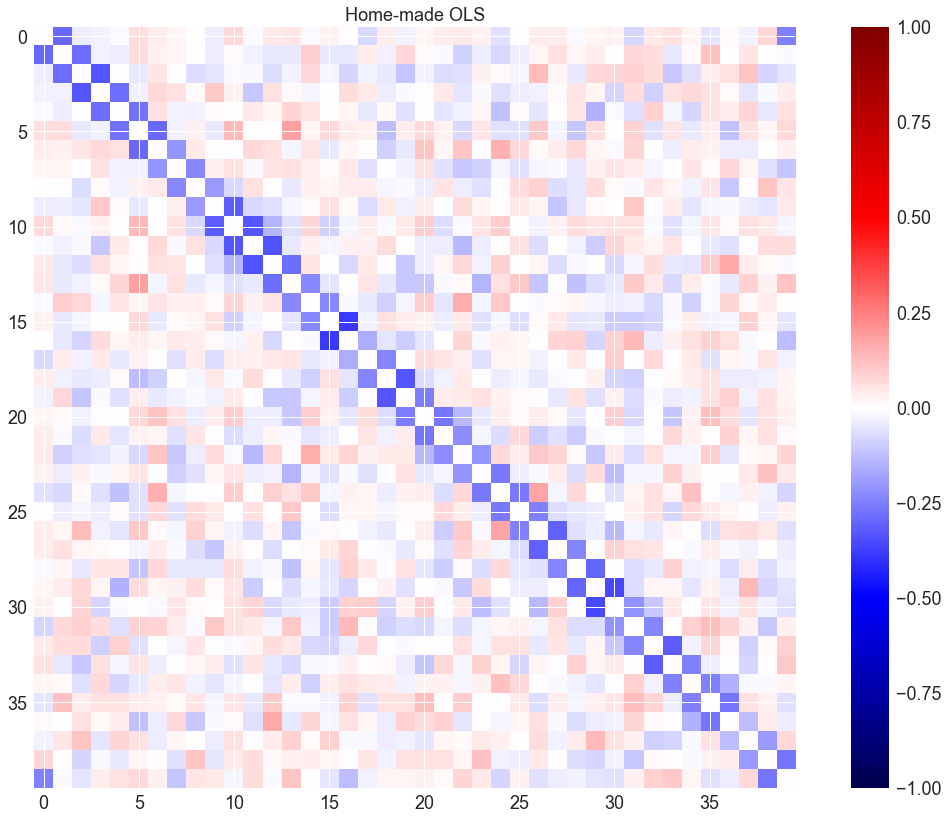

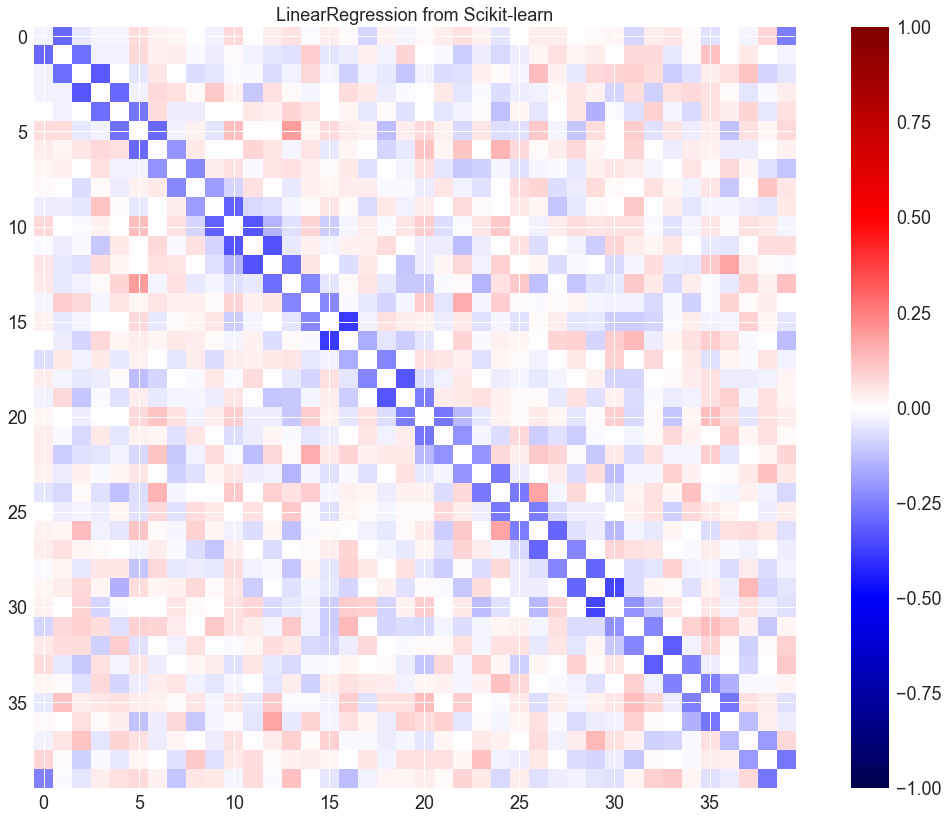

In [11]:
fig = plt.figure(figsize=(20, 14))
im = plt.imshow(J_own, **cmap_args)
plt.title("Home-made OLS", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
cb = fig.colorbar(im)
cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=18)

fig = plt.figure(figsize=(20, 14))
im = plt.imshow(J_sk, **cmap_args)
plt.title("LinearRegression from Scikit-learn", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
cb = fig.colorbar(im)
cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=18)

plt.show()

We can see that our model for the least squares method performes close to the benchmark from Scikit-learn. It is interesting to note that OLS considers both $J_{j, j + 1} = -0.5$ and $J_{j, j - 1} = -0.5$ as valid matrix elements for $J$.

### Ridge regression

Having explored the ordinary least squares we move on to ridge regression. In ridge regression we include a _regularizer_. This involves a new cost function which leads to a new estimate for the weights $\omega$. This results in a penalized regression problem. The cost function is given by

\begin{align}
    C(X, \omega; \lambda) = ||X\omega - y||^2 + \lambda ||\omega||^2
    = (X\omega - y)^T(X\omega - y) + \lambda \omega^T\omega.
\end{align}

Finding the extremum of this function yields the weights

\begin{align}
    \omega(\lambda) = \frac{X^Ty}{X^TX + \lambda} \to \frac{\omega_{\text{LS}}}{1 + \lambda},
\end{align}

where $\omega_{\text{LS}}$ is the weights from ordinary least squares. The last assumption assumes that $X$ is orthogonal, which it is not. We will therefore resort to solving the equation as it stands on left hand side.

In [12]:
def get_ridge_weights(x: np.ndarray, y: np.ndarray, _lambda: float) -> np.ndarray:
    return x.T @ y @ scl.inv(
        x.T @ x + np.eye(x.shape[1], x.shape[1]) * _lambda
    )

In [13]:
_lambda = 0.1

In [14]:
omega_ridge = get_ridge_weights(X_train_own, y_train, np.array([_lambda]))

In [15]:
clf_ridge = skl.Ridge(alpha=_lambda).fit(X_train, y_train)

In [16]:
J_ridge_own = omega_ridge[1:].reshape(L, L)
J_ridge_sk = clf_ridge.coef_.reshape(L, L)

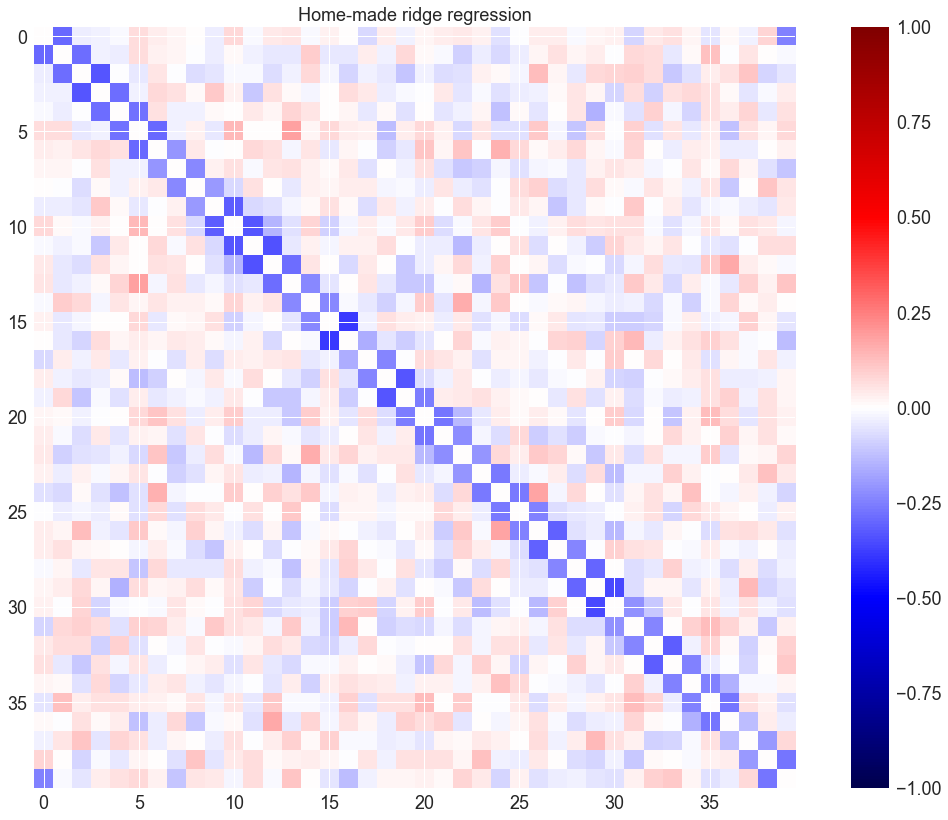

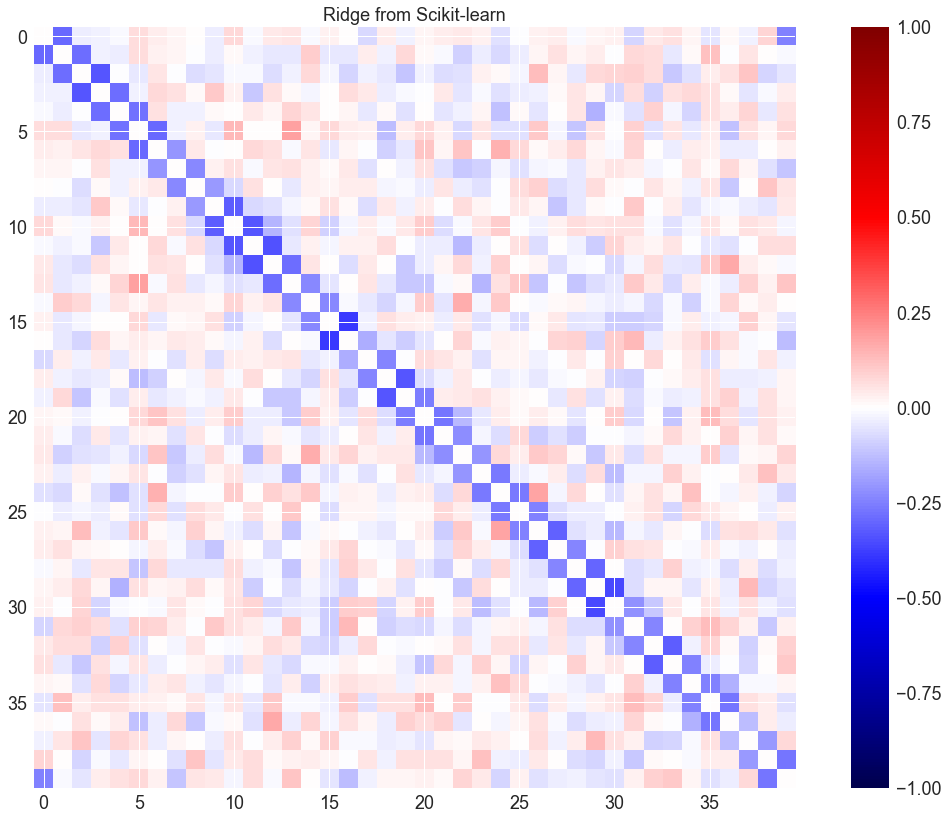

In [17]:
fig = plt.figure(figsize=(20, 14))
im = plt.imshow(J_ridge_own, **cmap_args)
plt.title("Home-made ridge regression", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
cb = fig.colorbar(im)
cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=18)

fig = plt.figure(figsize=(20, 14))
im = plt.imshow(J_ridge_sk, **cmap_args)
plt.title("Ridge from Scikit-learn", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
cb = fig.colorbar(im)
cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=18)

plt.show()

In other words, our implementation of ridge regression seems to match well with the benchmark from Scikit-learn. We can also see the same symmetry pattern as for OLS.

### LASSO regression

In the _Least Absolute Shrinkage and Selection Operator_ (LASSO)-method we get a third cost function.

\begin{align}
    C(X, \omega; \lambda) =
    ||X\omega - y||^2 + \lambda ||\omega||
    = (X\omega - y)^T(X\omega - y) + \lambda \sqrt{\omega^T\omega}.
\end{align}

Finding the extremal point of this cost function is not so straight-forward as in least squares and ridge. We will therefore rely solely on the function ``Lasso`` from Scikit-learn.

In [18]:
clf_lasso = skl.Lasso(alpha=_lambda).fit(X_train, y_train)
J_lasso_sk = clf_lasso.coef_.reshape(L, L)

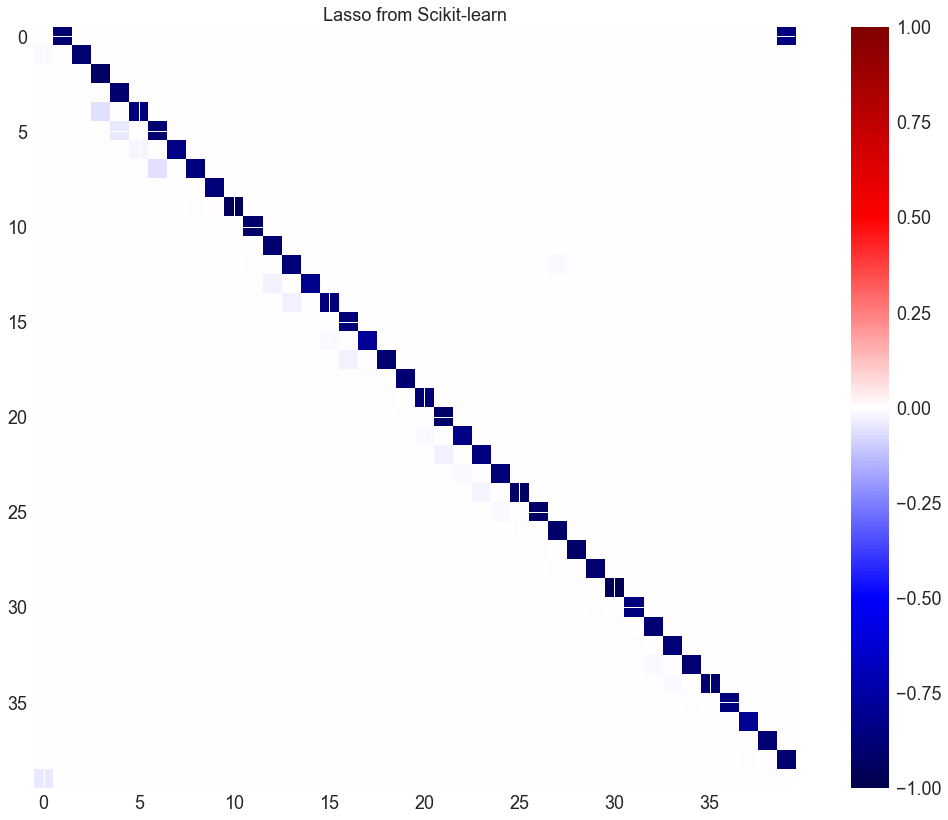

In [19]:
fig = plt.figure(figsize=(20, 14))
im = plt.imshow(J_lasso_sk, **cmap_args)
plt.title("Lasso from Scikit-learn", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
cb = fig.colorbar(im)
cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=18)

plt.show()

It is quite striking how LASSO breaks the symmetry of the coupling constant as opposed to ridge and OLS. We get a sparse solution with $J_{j, j + 1} = -1$.

## Performance of the different models

In order to judge which model performs best at varying values of $\lambda$ (for ridge and LASSO) we compute $R^2$ which is given by

\begin{align}
    R^2 = 1 - \frac{(y - \hat{y})^2}{(y - \bar{y})^2},
\end{align}

where $y$ is a vector with the true values of the energy, $\hat{y}$ is the predicted values of $y$ from the models and $\bar{y}$ is the mean of $\hat{y}$.

In [20]:
def r_squared(y, y_hat):
    return 1 - np.sum((y - y_hat) ** 2) / np.sum((y - np.mean(y_hat)) ** 2)

This is the same metric used by Scikit-learn for their regression models when scoring.

In [21]:
y_hat = clf.predict(X_test)
r_test = r_squared(y_test, y_hat)
sk_r_test = clf.score(X_test, y_test)

assert abs(r_test - sk_r_test) < 1e-2

## Performance as  function of the regularization parameter

We see how the different models perform for a different set of values for $\lambda$.

  0%|          | 0/10 [00:00<?, ?it/s]/Users/Schoyen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
100%|██████████| 10/10 [00:19<00:00,  1.91s/it]


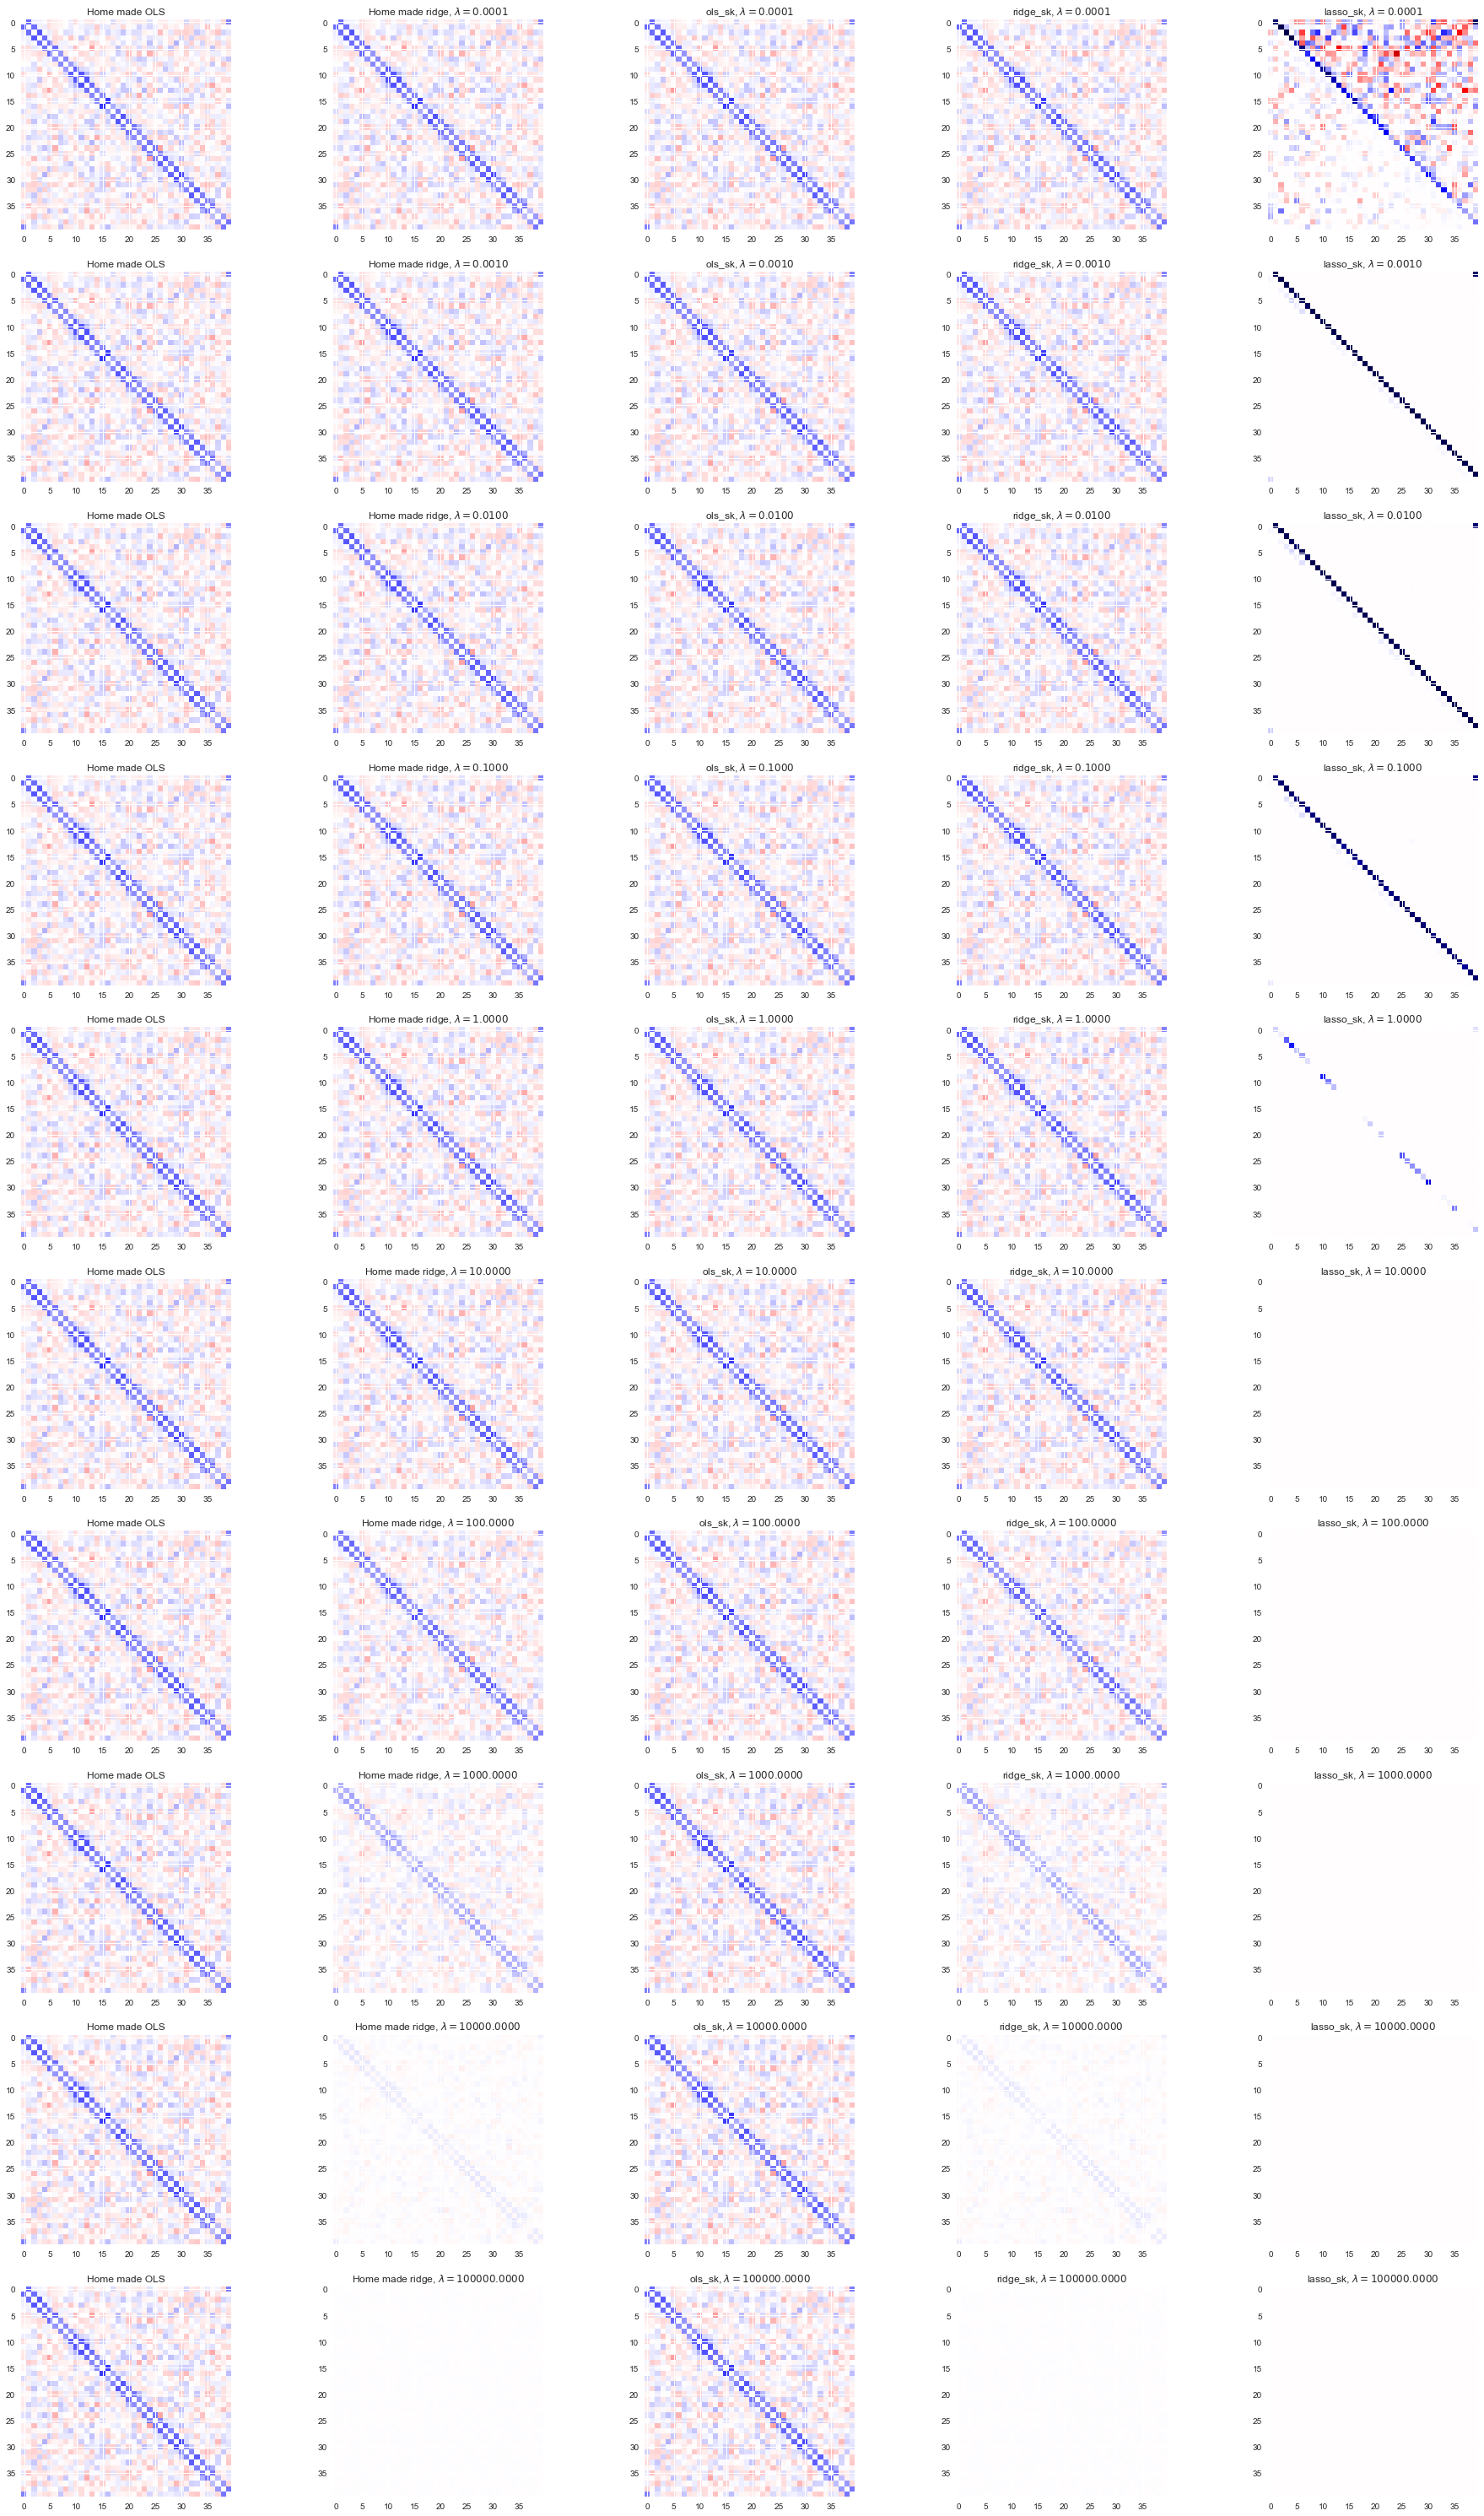

In [22]:
lambdas = np.logspace(-4, 5, 10)

train_errors = {
    "ols_own": np.zeros(lambdas.size),
    "ols_sk": np.zeros(lambdas.size),
    "ridge_own": np.zeros(lambdas.size),
    "ridge_sk": np.zeros(lambdas.size),
    "lasso_sk": np.zeros(lambdas.size)
}

test_errors = {
    "ols_own": np.zeros(lambdas.size),
    "ols_sk": np.zeros(lambdas.size),
    "ridge_own": np.zeros(lambdas.size),
    "ridge_sk": np.zeros(lambdas.size),
    "lasso_sk": np.zeros(lambdas.size)
}

plot_counter = 1

fig = plt.figure(figsize=(32, 54))

for i, _lambda in enumerate(tqdm.tqdm(lambdas)):
    omega = get_ols_weights(X_train_own, y_train)
    y_hat_train = X_train_own @ omega
    y_hat_test = X_test_own @ omega

    train_errors["ols_own"][i] = r_squared(y_train, y_hat_train)
    test_errors["ols_own"][i] = r_squared(y_test, y_hat_test)

    plt.subplot(10, 5, plot_counter)
    plt.imshow(omega[1:].reshape(L, L), **cmap_args)
    plt.title("Home made OLS")
    plot_counter += 1

    omega = get_ridge_weights(X_train_own, y_train, _lambda)
    y_hat_train = X_train_own @ omega
    y_hat_test = X_test_own @ omega

    train_errors["ridge_own"][i] = r_squared(y_train, y_hat_train)
    test_errors["ridge_own"][i] = r_squared(y_test, y_hat_test)

    plt.subplot(10, 5, plot_counter)
    plt.imshow(omega[1:].reshape(L, L), **cmap_args)
    plt.title(r"Home made ridge, $\lambda = %.4f$" % _lambda)
    plot_counter += 1

    for key, method in zip(
        ["ols_sk", "ridge_sk", "lasso_sk"],
        [skl.LinearRegression(), skl.Ridge(alpha=_lambda), skl.Lasso(alpha=_lambda)]
    ):
        method = method.fit(X_train, y_train)

        train_errors[key][i] = method.score(X_train, y_train)
        test_errors[key][i] = method.score(X_test, y_test)

        omega = method.coef_.reshape(L, L)

        plt.subplot(10, 5, plot_counter)
        plt.imshow(omega, **cmap_args)
        plt.title(r"%s, $\lambda = %.4f$" % (key, _lambda))
        plot_counter += 1

plt.show()

We can see that LASSO quite fast reaches a good solution for low values of $\lambda$, but will "wither" when we increase $\lambda$ too much. Ridge is more stable over a larger range of values for $\lambda$, but eventually also fades away.

## Finding the optimal value of $\lambda$

To determine which value of $\lambda$ is best we plot the accuracy of the models when predicting the training and the testing set. We expect the accuracy of the training set to be quite good, but if the accuracy of the testing set is much lower this tells us that we might be subject to an overfit model. The ideal scenario is an accuracy on the testing set that is close to the accuracy of the training set.

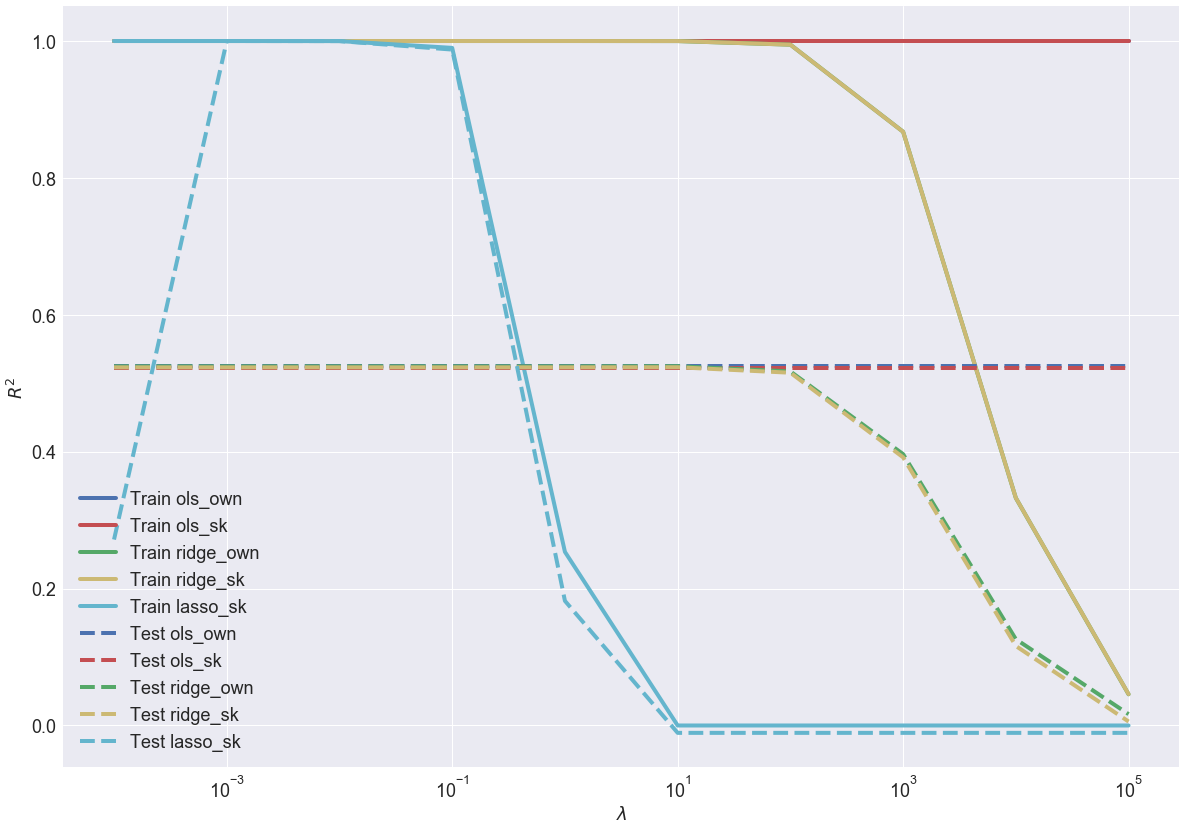

In [23]:
fig = plt.figure(figsize=(20, 14))

colors = {
    "ols_own": "b",
    "ridge_own": "g",
    "ols_sk": "r",
    "ridge_sk": "y",
    "lasso_sk": "c"
}

for key in train_errors:
    plt.semilogx(
        lambdas,
        train_errors[key],
        colors[key],
        label="Train {0}".format(key),
        linewidth=4.0
    )

for key in test_errors:
    plt.semilogx(
        lambdas,
        test_errors[key],
        colors[key] + "--",
        label="Test {0}".format(key),
        linewidth=4.0
    )
#plt.semilogx(lambdas, train_errors["ols_own"], label="Train (OLS own)")
#plt.semilogx(lambdas, test_errors["ols_own"], label="Test (OLS own)")

plt.legend(loc="best", fontsize=18)
plt.xlabel(r"$\lambda$", fontsize=18)
plt.ylabel(r"$R^2$", fontsize=18)
plt.tick_params(labelsize=18)
plt.show()

From the above figure we can see that LASSO with $\lambda = 10^{-2}$ achieve a very good accuracy on the test set. This by far surpases the other models for all values of $\lambda$.